# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données

Nous avons choisi 4 mots : gauche, droite, milieu, bas.
Pour chaque mot, nous avons au minimum 31 enregistrements différents.
Nous avons dû faire un prétraitement, afin notamment de convertir les fichiers en wav et pour certains de les découper.

In [1]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import librosa
import librosa.display
import IPython.display as ipd
import glob
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

## Les données
On va utiliser le jeu de données <a href="https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html">"speech commands"</a>.

In [2]:
basedir="./Sons/"
# à adapter selon l'ordinateur
classes = ['Gauche', 'Droite','Milieu', 'Bas'] #Nos classes
verbose = False
taille_mfcc=13

In [3]:
for cl in classes:
    listSons = glob.glob(basedir+cl+"/*.wav")
    print(len(listSons), "sons de la classe ", cl)

33 sons de la classe  Gauche
35 sons de la classe  Droite
31 sons de la classe  Milieu
33 sons de la classe  Bas


## Calcul des MFCCs de tous les sons

### On va partir d'une base de 24 sons de chaque classe

In [4]:
def build_MFCC(mfcc, nb):
    global verbose
    i=0
    for cl in classes:
        listeSons = glob.glob(basedir+cl+"/*.wav")
        for s in listeSons[:nb]:
            if verbose:
                print("###",s,"###")
            (sig,rate) = librosa.load(s)
            mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
            if verbose:
                print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
            mfcc[i] = np.mean(mfcc_feat, axis=1)
            i += 1
    if verbose:
        print("shape : ",mfcc.shape)
    return mfcc


In [5]:
nb=20
lesMfcc = np.empty(shape=(nb*len(classes), 13), dtype=float)
lesMfcc = build_MFCC(lesMfcc, nb)


### Classification linéaire des sons

Il ne reste plus que l'étape de classification des sons. On va utiliser pour cela une méthode simple de classification linéaire: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">la régression logistique</a>.

In [6]:
# création de l'objet de regression logistique
logisticRegr = LogisticRegression()

# classes des sons:
yTrain = []
for clNumber in range(len(classes)):
    yTrain += [clNumber]*nb

# apprentissage de la séparation en utilisation des données pour lesquelles on connait la classe
logisticRegr.fit(lesMfcc, yTrain)


C:\Users\Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
scaler = preprocessing.StandardScaler().fit(lesMfcc)

print(scaler.mean_)
print(scaler.scale_)

xTrain = scaler.transform(lesMfcc)

[-4.69089787e+02  8.63889294e+01  1.39268181e+01  1.89268923e+01
  1.78328517e+00  7.06519408e+00 -2.39426885e+00 -3.99301274e-01
 -4.65427798e+00  7.91415403e-01 -2.48054977e+00 -1.13191820e-01
 -3.19836352e+00]
[76.32810292 27.55803413 10.80640636 11.58393458  9.39365411  7.53728595
  7.70266053  7.26641346  5.59684665  4.74261308  6.5263291   4.46761364
  4.04859528]


In [8]:
ypred = logisticRegr.predict(xTrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.7250000000000001
train accuracy score =  0.725


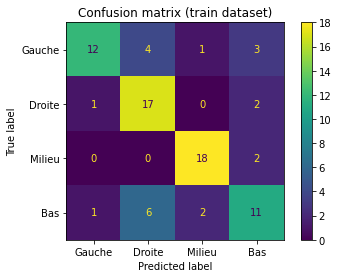

In [9]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

### Evaluation de la classification

Pour évaluer de façon juste, on va utiliser des sons qui n'ont pas déjà servi à l'apprentissage. On va par exemple prendre les nb derniers de chaque classe.

In [10]:
nbTest = 10
lesMfccTest = np.empty(shape=(nbTest*len(classes), 13), dtype=float)
lesMfccTest = build_MFCC(lesMfccTest, nbTest)
xTest = scaler.transform(lesMfccTest)
yTest = []
for clNumber in range(len(classes)):
    yTest += [clNumber]*nbTest

In [11]:
predTest = logisticRegr.predict(xTest)
print("test F1 score = ", f1_score(yTest, predTest, average = 'micro'))
print("test accuracy score = ", accuracy_score(yTest, predTest))


test F1 score =  0.675
test accuracy score =  0.675


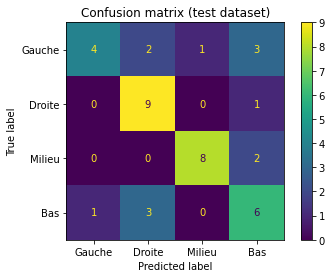

In [12]:
cm = confusion_matrix(yTest, predTest, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

On peut voir que les mots milieu et droite sont assez bien reconnus, le mot bas un peu moins, et le mot gauche est le mot le moins bien reconnu dans notre liste.

## Classification par sac de descripteurs

In [13]:
def build_bof(k, lesLabels, dimSons):
    '''méthode pour construire le Bag Of Features d'un échantillon de sons'''
    bofs = np.empty(shape = (0, k), dtype = int) # tableau des BoF
    i = 0 # indice pour le parcours de MFCC

    for nbS in dimSons: # Parcours des sons
        tmpBof = np.array([0]*k) # initialisation du BOF pour le son courant
        j = 0
        while j < nbS: # pour chaque MFCC de ce son
            tmpBof[lesLabels[i]] += 1
            j+=1
            i+=1
        tmpBof = tmpBof/nbS # transformation en pourcentage
        copyBof = tmpBof.copy()
        bofs = np.append(bofs, [copyBof], 0)

    return bofs

def build_MFCC_for_bof(listSons, lesMfcc, dimSons, nb = 20):
    '''méthode pour construite le tableau des MFCC d'un échantillon de sons'''
    global taille_mfcc
    for s in listSons[:nb]: # on prends les nb premiers sons de la liste 1
        sig, rate = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=taille_mfcc) # on calcule les MFCC du son

        lesMfcc = np.append(lesMfcc, mfcc_feat.transpose(), axis = 0) # on ajoute les MFCC du son à notre array
        dimSons.append(mfcc_feat.shape[1]) # et on "déclare" le nombre de MFCC du son
    return lesMfcc

In [14]:
# partie d'initialisation des fichiers sons
################################################################################################################

basedir="./Sons/"
class1 = 'Gauche'
class2 = 'Droite'
class3 = 'Milieu'
class4 = 'Bas'

listSons1 = glob.glob(basedir+class1+"/*.wav")
listSons2 = glob.glob(basedir+class2+"/*.wav")
listSons3 = glob.glob(basedir+class3+"/*.wav")
listSons4 = glob.glob(basedir+class4+"/*.wav")



# partie construction du vecteur de tous les MFCC
################################################################################################################

nb = 20 # nombre de sons dans l'échantillon
lesMfcc = np.empty(shape = (0, 13), dtype = float) # tableau de tous les MFCC (de tous les sons)
dimSons = []
lesMfcc = build_MFCC_for_bof(listSons1, lesMfcc, dimSons, nb)
lesMfcc = build_MFCC_for_bof(listSons2, lesMfcc, dimSons, nb)
lesMfcc = build_MFCC_for_bof(listSons3, lesMfcc, dimSons, nb)
lesMfcc = build_MFCC_for_bof(listSons4, lesMfcc, dimSons, nb)


nbTest=10
lesMfccTest = np.empty(shape=(0, 13), dtype=float)
dimSonsTest = []
# on va prendre les nb derniers sons
lesMfccTest = build_MFCC_for_bof(listSons1[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
lesMfccTest = build_MFCC_for_bof(listSons2[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
lesMfccTest = build_MFCC_for_bof(listSons3[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
lesMfccTest = build_MFCC_for_bof(listSons4[-nbTest:], lesMfccTest, dimSonsTest, nbTest)


# ici on va tester l'apprentissage en faisant varier le nombre de clusters k

# apprentissage
################################################################################################################

test_k_results = {}
train_k_results = {}

for k in range(2, 15):
    monKmeans = KMeans(n_clusters = k) # création de l'objet
    monKmeans.fit(lesMfcc) # apprentissage
    lesLabels = monKmeans.labels_ # tableau des numéros de "regroupement" de toutes nos MFCC

    bofs = build_bof(k, lesLabels, dimSons)

    logisticRegr = LogisticRegression() # création de l'objet de regression logistique

    # classes des sons (0 pour classe1 et 1 pour classe2)
    groundTruth = [0]*nb + [1]*nb + [2]*nb + [3]*nb

    logisticRegr.fit(bofs, groundTruth) # apprentissage
    resTrain = logisticRegr.predict(bofs)
    scoreTrain = f1_score(groundTruth, resTrain, average='micro')
    print(f'train score pour k = {k}:', scoreTrain)
    train_k_results[k] = scoreTrain



    lesLabelsTest = monKmeans.predict(lesMfccTest) # prédiction des partitions pour ces MFCCs



    bofsTest = build_bof(k, lesLabelsTest, dimSonsTest)

    groundTruthTest = [0]*nbTest + [1]*nbTest + [2]*nbTest + [3]*nbTest
    resTest = logisticRegr.predict(bofsTest)
    scoreTest = f1_score(groundTruthTest,resTest, average='micro')
    print(f'test score pour k = {k}:', scoreTest)
    test_k_results[k] = scoreTest

train score pour k = 2: 0.3125
test score pour k = 2: 0.3
train score pour k = 3: 0.3
test score pour k = 3: 0.3
train score pour k = 4: 0.4125
test score pour k = 4: 0.425
train score pour k = 5: 0.575
test score pour k = 5: 0.525
train score pour k = 6: 0.5125
test score pour k = 6: 0.5
train score pour k = 7: 0.625
test score pour k = 7: 0.45
train score pour k = 8: 0.6
test score pour k = 8: 0.47500000000000003
train score pour k = 9: 0.7250000000000001
test score pour k = 9: 0.575
train score pour k = 10: 0.7
test score pour k = 10: 0.575
train score pour k = 11: 0.7125
test score pour k = 11: 0.575
train score pour k = 12: 0.7375
test score pour k = 12: 0.65
train score pour k = 13: 0.75
test score pour k = 13: 0.625
train score pour k = 14: 0.7375
test score pour k = 14: 0.55


In [15]:
k = 12
print(f"k max = {k}")

for taille_mfcc in range(13, 20):
    lesMfcc = np.empty(shape = (0, taille_mfcc), dtype = float) # tableau de tous les MFCC (de tous les sons)
    dimSons = []
    lesMfcc = build_MFCC_for_bof(listSons1, lesMfcc, dimSons, nb)
    lesMfcc = build_MFCC_for_bof(listSons2, lesMfcc, dimSons, nb)
    lesMfcc = build_MFCC_for_bof(listSons3, lesMfcc, dimSons, nb)
    lesMfcc = build_MFCC_for_bof(listSons4, lesMfcc, dimSons, nb)


    lesMfccTest = np.empty(shape=(0, taille_mfcc), dtype=float)
    dimSonsTest = []
    # on va prendre les nb derniers sons
    lesMfccTest = build_MFCC_for_bof(listSons1[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
    lesMfccTest = build_MFCC_for_bof(listSons2[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
    lesMfccTest = build_MFCC_for_bof(listSons3[-nbTest:], lesMfccTest, dimSonsTest, nbTest)
    lesMfccTest = build_MFCC_for_bof(listSons4[-nbTest:], lesMfccTest, dimSonsTest, nbTest)

    monKmeans = KMeans(n_clusters = k) # création de l'objet
    monKmeans.fit(lesMfcc) # apprentissage
    lesLabels = monKmeans.labels_ # tableau des numéros de "regroupement" de toutes nos MFCC

    bofs = build_bof(k, lesLabels, dimSons)

    logisticRegr = LogisticRegression() # création de l'objet de regression logistique

    # classes des sons (0 pour classe1 et 1 pour classe2)
    groundTruth = [0]*nb + [1]*nb + [2]*nb + [3]*nb

    logisticRegr.fit(bofs, groundTruth) # apprentissage
    resTrain = logisticRegr.predict(bofs)
    scoreTrain = f1_score(groundTruth, resTrain, average='micro')
    print(f'train score pour k = {k}:', scoreTrain)
    train_k_results[k] = scoreTrain


    lesLabelsTest = monKmeans.predict(lesMfccTest) # prédiction des partitions pour ces MFCCs

    bofsTest = build_bof(k, lesLabelsTest, dimSonsTest)

    groundTruthTest = [0]*nbTest + [1]*nbTest + [2]*nbTest + [3]*nbTest
    resTest = logisticRegr.predict(bofsTest)
    scoreTest = f1_score(groundTruthTest,resTest, average='micro')
    print(f'test score pour taille Mfcc = {taille_mfcc}:', scoreTest)

k max = 12
train score pour k = 12: 0.6875
test score pour taille Mfcc = 13: 0.65
train score pour k = 12: 0.75
test score pour taille Mfcc = 14: 0.675
train score pour k = 12: 0.7125
test score pour taille Mfcc = 15: 0.7
train score pour k = 12: 0.675
test score pour taille Mfcc = 16: 0.5
train score pour k = 12: 0.7
test score pour taille Mfcc = 17: 0.675
train score pour k = 12: 0.7375
test score pour taille Mfcc = 18: 0.7
train score pour k = 12: 0.7
test score pour taille Mfcc = 19: 0.7
